# Pokemon battle analysis

Hello trainers! Welcome to our analysis project on this vast world of Pokemon battling. Here we will be focusing mainly on the battle aspect of Pokemon, what it takes to be the best Pokemon battler and what Pokemon are the strongest. We will be using two different datasets for this analysis. The first dataset is a database of all Pokemon that have been discovered up to generation 6. The second dataset contains the battles. Each of the pokemons in our dataset has been assigned a number. This number is used to represent the Pokemon fighting in the battle dataset.

Let's start off by setting up the libraries needed for our analysis!

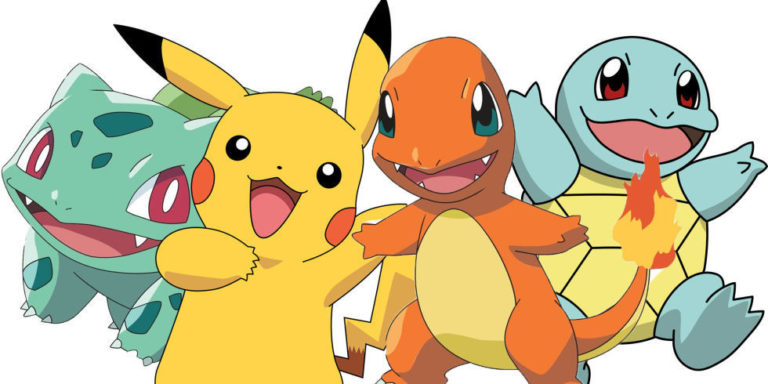

In [32]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

For anyone that is not familiar with Pokemon or has been out of the scene for some time, here is a refresher. In the first dataset which contains 800 Pokemon (including Mega evolutions), each Pokemon has its name, primary and secondary type, combat stats, which generation it originates from and if it's a Legendary Pokemon or not. 

The main columns we will be looking at are the **types** and **stats**. A Pokemon has a primary type. This represents what kind of Pokemon it is. A Pokemon can have several types, for example, grass, water, fire, dragon etc. It's also possible for a Pokemon to be two types. This is however not necessary. Some Pokemon only have one type. 

A Pokemons' stats is a numerical value for his strength in several attributes. For example Attack, Defence, Special attack and Speed. The higher this value is, the stronger this Pokemon is in that stat. 



In [33]:
pokemon = pd.read_csv("pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


Lets look at our battle's database! Second and first colum represent Pokemons that had battled and third colum tells us who was the winner of the battle. We used database from Kaggle. This database was generated by custom algorithm that does not take into account some of the game charasteristic - like pokemon level or the moves Pokemon uses.

In [34]:
battles = pd.read_csv("combats.csv")
battles.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


## Cleanup

First we need to identify any missing data. We can see that there is one Pokemon name missing and 386 type 2 marked as NaN. That many missing type 2's is to be expected since Pokemon don't neccessarily have to have more than one type. We still want to identify how many there are and change it from NaN to 0. We also need to find that one missing name and fix it. 

In [35]:
print(pokemon.isnull().sum())
np.where(pd.isnull(pokemon['Name']))

#               0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64


(array([62], dtype=int64),)

As seen above, we have spotted the missing name. It's in row 62. 

In [36]:
print(pokemon['Name'][61])
print(pokemon['Name'][62])
print(pokemon['Name'][63])

Mankey
nan
Growlithe


To fill it in, we print out the neighbouring Pokemon name and use our expert Pokemon knowledge to find out that the missing name is indeed Mankeys evolution, Primeape. So we fill that missing value in and change all the missing type 2 with 0's. 

In [37]:
pokemon.at[62, 'Name'] = 'Primeape'
pokemon_no_nan = pokemon.fillna(0)
print(pokemon_no_nan.isnull().sum())

#             0
Name          0
Type 1        0
Type 2        0
HP            0
Attack        0
Defense       0
Sp. Atk       0
Sp. Def       0
Speed         0
Generation    0
Legendary     0
dtype: int64


Now we want to merge the two datasets together. The Pokemon data and the battles. We want to show how successful each Pokemon is at battling. We do this by adding a column named **Percentage_win**. After merging the datasets together we checked again for NAN values. Oho! They were there. They represent Pokemon that did not have a chance to battle :( Those poor Pokemon!

In [38]:
win_total = battles.Winner.value_counts()
win_number = battles.groupby('Winner').count() #number of wins
first_count = battles.groupby('Second_pokemon').count()
second_count = battles.groupby('First_pokemon').count()

win_number = win_number.sort_index()
win_number['Fights_total'] = first_count.Winner + second_count.Winner
win_number['Percentage_win'] = win_number.First_pokemon/win_number['Fights_total']
win_number.head()

merged_data = pd.merge(pokemon_no_nan,win_number,left_on = '#',right_index = True,how='left')

merged_data[merged_data['Percentage_win'].isnull()]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,First_pokemon,Second_pokemon,Fights_total,Percentage_win
11,12,Blastoise,Water,0,79,83,100,85,105,78,1,False,NaN,NaN,NaN,NaN
32,33,Sandshrew,Ground,0,50,75,85,20,30,40,1,False,NaN,NaN,NaN,NaN
45,46,Wigglytuff,Normal,Fairy,140,70,45,85,50,45,1,False,NaN,NaN,NaN,NaN
65,66,Poliwag,Water,0,40,50,40,40,40,90,1,False,NaN,NaN,NaN,NaN
77,78,Victreebel,Grass,Poison,80,105,65,100,70,70,1,False,NaN,NaN,NaN,NaN
89,90,Magneton,Electric,Steel,50,60,95,120,70,70,1,False,NaN,NaN,NaN,NaN
143,144,Ditto,Normal,0,48,48,48,48,48,48,1,False,NaN,NaN,NaN,NaN
182,183,Ariados,Bug,Poison,70,90,70,60,60,40,2,False,NaN,NaN,NaN,NaN
230,231,Shuckle,Bug,Rock,20,10,230,10,230,5,2,False,NaN,NaN,NaN,NaN
235,236,Ursaring,Normal,0,90,130,75,75,75,55,2,False,NaN,NaN,NaN,NaN


Lets get rid of them since they will not help us to determine the winner! And gone :)

In [39]:
merged_data = merged_data.dropna(how='any',axis=0)
merged_data[merged_data['Percentage_win'].isnull()]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,First_pokemon,Second_pokemon,Fights_total,Percentage_win


## Analysis

Let's warm up by taking a look at who are the top 10 loser Pokemon based on our battle data. 

As a side note, each column on the graphs ahead are colour coded to represent the primary type of said Pokemon. 

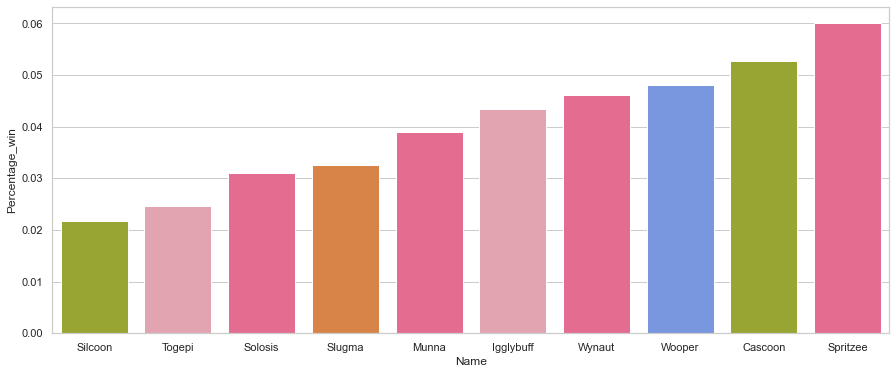

In [40]:
top_10_losers = merged_data.sort_values(by=['Percentage_win']).head(10)
type_related_colors = ['#A8B820', '#EE99AC', '#F85888', '#F08030', '#F85888', '#EE99AC', '#F85888', '#6890F0', '#A8B820', '#F85888']
plt.figure(figsize=(15,6))
sn.set(style="whitegrid")
ax = sn.barplot(x="Name", y="Percentage_win", data=top_10_losers, palette=type_related_colors)

We can see that majority of our loosers are Dark Pink and Light pink representing Psychic and Fairy pokemons.Let´s dig deeper!

Now the opposite, let's take a look at who are the most victorious Pokemon!

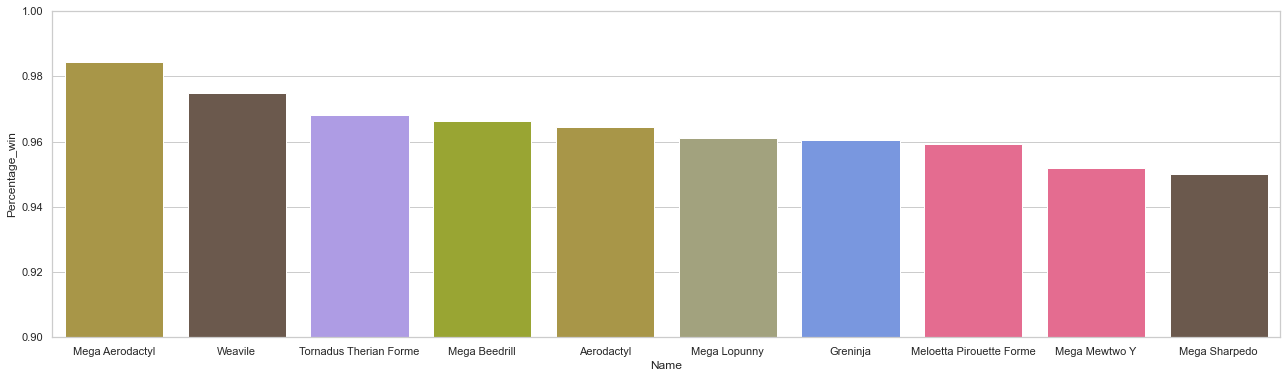

In [41]:
top_10_winners = merged_data.sort_values(by=['Percentage_win'],ascending=False).head(10)
type_related_colors = ['#B8A038', '#705848', '#A890F0', '#A8B820', '#B8A038', '#A8A878', '#6890F0', '#F85888', '#F85888', '#705848']
plt.figure(figsize=(22,6))
plt.ylim(0.9,1)
sn.set(style="whitegrid")
ax = sn.barplot(x="Name", y="Percentage_win", data=top_10_winners, palette=type_related_colors, seed=1)

It's clear that the Mega evolutions are doing well in battle. But not all of them are Megas. What is making these Pokemon so successful in battle? Let's take a look at the correlation between the stats and the win rate to find out what stat is leading to higher win rates.

<AxesSubplot:>

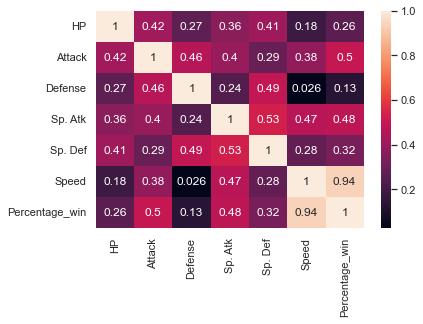

In [42]:
prep_for_corellation = merged_data[['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Percentage_win']]
corr_matrix = prep_for_corellation.corr()
sn.heatmap(corr_matrix,annot=True)

From the correlation matrix above there is clear evidence that the **Speed** stat has a lot to do with how successful a Pokemon is in battling. This makes a lot of sense because getting that first move in each turn really sets the tone for the outcome of a 1v1 Pokemon battle. Let's have a look at the Pokemon with the strongest **Speed** stat.

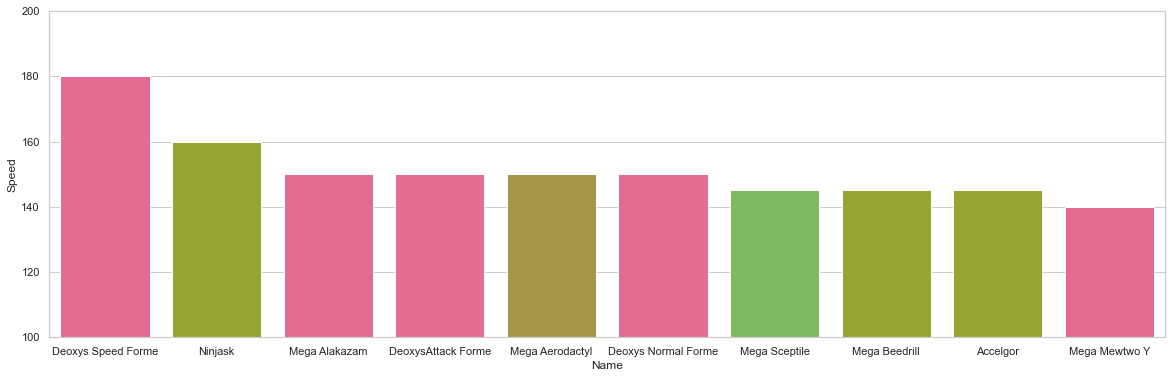

In [43]:
top_10_speedy = merged_data.sort_values(by=['Speed'],ascending=False).head(10)
type_related_colors = ['#F85888', '#A8B820', '#F85888', '#F85888', '#B8A038', '#F85888', '#78C850', '#A8B820', '#A8B820', '#F85888']
plt.figure(figsize=(20,6))
plt.ylim(100, 200)
sn.set(style="whitegrid")
ax = sn.barplot(x="Name", y="Speed", data=top_10_speedy, palette=type_related_colors, seed=1)

Suprisingly our highest grossing winner - Mega Aerodactyl is not even in the top 3 even though **Speed** has the biggest corellation to percentage of won battles.Let's look into it!

ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (6).

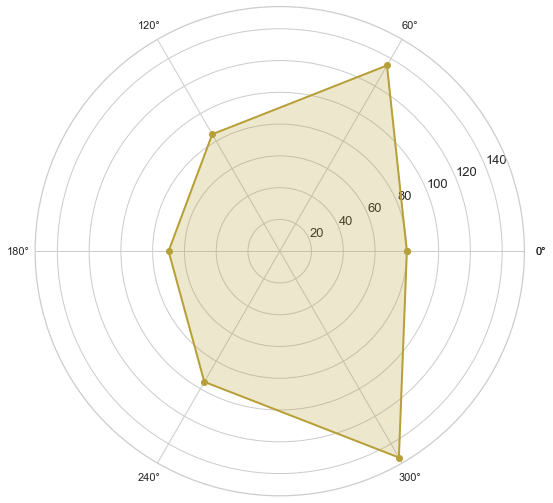

In [44]:
labels=np.array(['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed'])
stats=merged_data.loc[154,labels].values

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
# close the plot
stats=np.concatenate((stats,[stats[0]]))
angles=np.concatenate((angles,[angles[0]]))
fig=plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2, color='#B8A038')
plt.yticks(size=13)
plt.ylim(0)
ax.fill(angles, stats, alpha=0.25, color='#B8A038')
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.set_title('Mega Aerodactyl')
ax.grid(True)

As we can see his **speed** is high, but not extraordinary. It's noteworthy how balanced his priority stats are. **Speed, defence and attack** are all very respectable. Let's take a look at the top Speed Pokemon, **Deoxys Speed Forme**.

In [ ]:
stats=merged_data.loc[431,labels].values

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
stats=np.concatenate((stats,[stats[0]]))
angles=np.concatenate((angles,[angles[0]]))
fig=plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2, color='#F85888')
plt.yticks(size=13)
plt.ylim(0)
ax.fill(angles, stats, alpha=0.25, color='#F85888')
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.set_title('Deoxys Speed Forme')
ax.grid(True)

NameError: name 'merged_data' is not defined

We can clearly see that **Deoxys Speed Forme** has insanely high **Speed** but very weak in all other stats compared to **Aerodactyl**

Since **Attack** has the second biggest correlation to percentage of wins lets look into it.


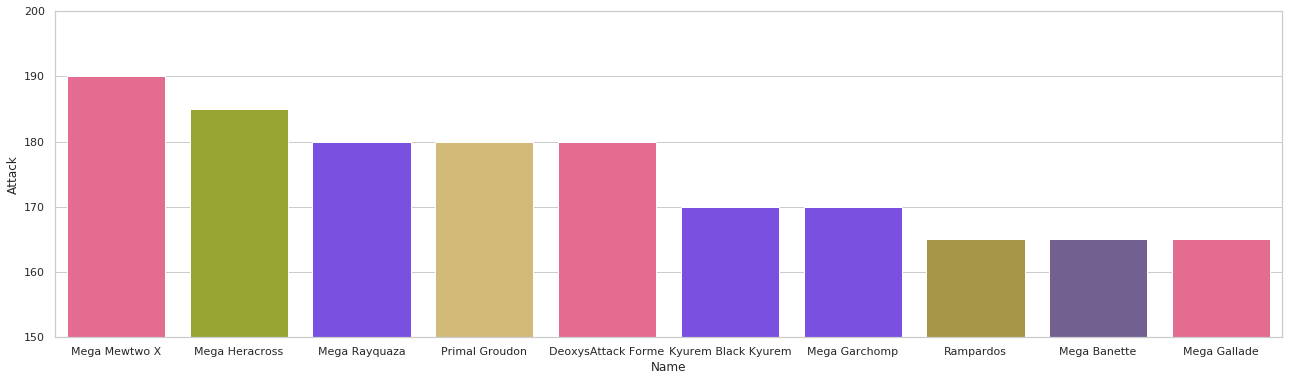

In [ ]:
top_10_attack = merged_data.sort_values(by=['Attack'],ascending=False).head(10)
type_related_colors = ['#F85888', '#A8B820', '#7038F8','#E0C068',  '#F85888', '#7038F8', '#7038F8', '#B8A038', '#705898','#F85888']
plt.figure(figsize=(22,6))
plt.ylim(150, 200)
sn.set(style="whitegrid")
ax = sn.barplot(x="Name", y="Attack", data=top_10_attack, palette=type_related_colors, seed=1)

Mega Aerodactyl is not even here! What's goin on? Let's look at combination of **Attack** and **Speed**

In [ ]:
sorted_attack_speed=merged_data.sort_values(['Speed','Attack'], ascending=[False, False]).head(20)
sorted_attack_speed[['Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
431,Deoxys Speed Forme,Psychic,0,50,95,90,95,90,180
315,Ninjask,Bug,Flying,61,90,45,50,50,160
429,DeoxysAttack Forme,Psychic,0,50,180,20,180,20,150
428,Deoxys Normal Forme,Psychic,0,50,150,50,150,50,150
154,Mega Aerodactyl,Rock,Flying,80,135,85,70,95,150
71,Mega Alakazam,Psychic,0,55,50,65,175,95,150
19,Mega Beedrill,Bug,Poison,65,150,40,15,80,145
275,Mega Sceptile,Grass,Dragon,70,110,75,145,85,145
678,Accelgor,Bug,0,80,70,40,100,60,145
164,Mega Mewtwo Y,Psychic,0,106,150,70,194,120,140


Let us look at the stats of the top 20 in **Speed** and **Attack**. When we looked at corellation heat graph those two are the most important factors for winning. Our Aerodactyl is however not in the top one space. Looking at the Pokemon before him we can see that their stats are not as rounded ! Thats why Mega Aerodactyl is our winner

We love type comparisons. So lets take a look at the distribution of **Attack** between each primary type on a swarmplot. 

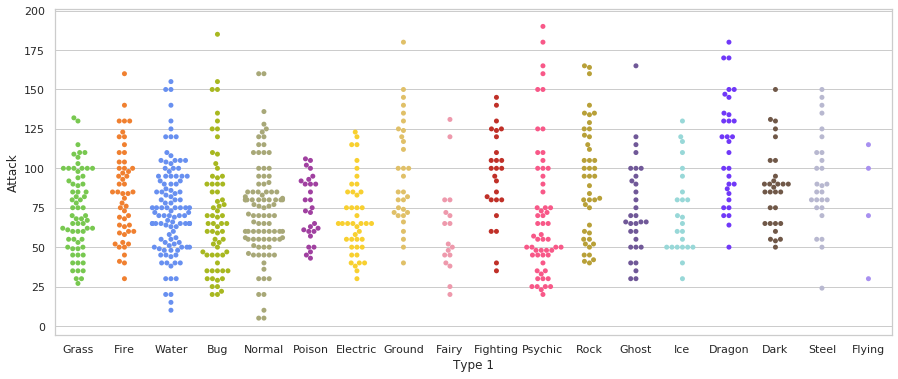

In [ ]:
type_related_colors = ['#78C850', '#F08030', '#6890F0', '#A8B820', '#A8A878', '#A040A0', '#F8D030', '#E0C068', '#EE99AC', '#C03028', '#F85888', '#B8A038', '#705898', '#98D8D8', '#7038F8', '#705848', '#B8B8D0', '#A890F0']
plt.figure(figsize=(15,6))
sn.set_style('whitegrid')
sn.swarmplot(x='Type 1', y='Attack', data=merged_data, palette=type_related_colors)

Just for support of the above grid, here below is a bar graph displaying how many Pokemon each primary **Type** has. 

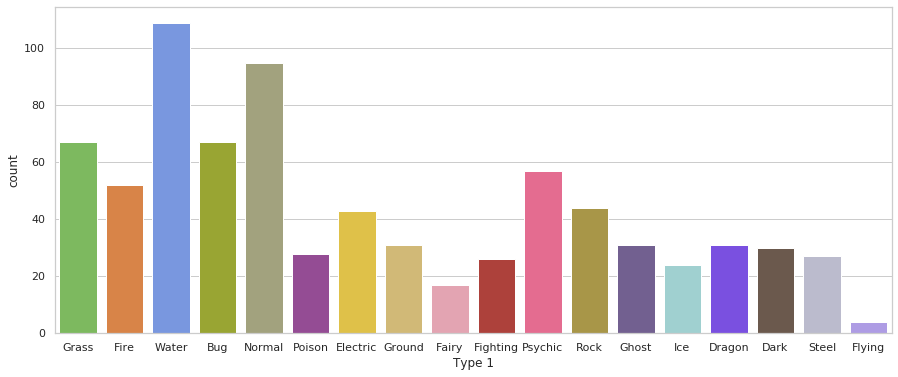

In [ ]:
plt.figure(figsize=(15,6))
sn.countplot(x='Type 1', data=merged_data, palette=type_related_colors)

It's clear that water is the most prevalent type. Just quickly for those wondering, flying has so few Pokemon because it is usually paired with another type and flying **most** of the time becomes the Pokemon second type. 

Lets see on distribution of winners depending on their primary **Type**

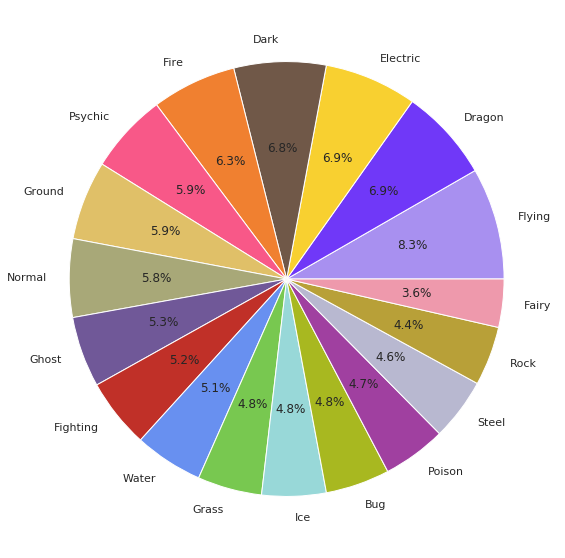

<Figure size 1080x432 with 0 Axes>

In [ ]:
highest_types = merged_data.groupby('Type 1').agg({"Percentage_win": "mean"}).sort_values(by = "Percentage_win",ascending=False)
type_related_colors = ['#A890F0', '#7038F8', '#F8D030', '#705848', '#F08030', '#F85888', '#E0C068', '#A8A878', '#705898', '#C03028', '#6890F0', '#78C850', '#98D8D8', '#A8B820', '#A040A0', '#B8B8D0', '#B8A038', '#EE99AC']
indexNamesArr = highest_types.index.values


fig1, ax1 = plt.subplots(figsize=(30,10))
ax1.pie(highest_types['Percentage_win'], labels= indexNamesArr , autopct='%1.1f%%', colors=type_related_colors)
plt.figure(figsize=(15,6))
plt.show()

**Flying** is the winner! Lets not forget hovewer that there are less than 10 Pokemon who have **Flying** as their primary **Type**. 

# Conclusion of data analysis
There was a lot of informations we got from this data set. Lets go over it so we can find out how to be the best trainer there ever was and win most battles ! 
### 1. Speed, speed, speed...

From our analysis we found out that speed plays high role in who is the winner in the pokemon battle. Pokemon with high Speed attack first in the battle that's why they have hudge adventage. Hovewer we also noticed that having a insanely high speed as in Deoxys Speed Forme where the other stats are very low compared to speed does not give you the advantage as you will be easily killed. Thats why having a stat rounded Pokemon like Mega Aerodactyl is the best strategy.

### 2. Types of Pokemon and the affect is has on the battle.

Highest winning Pokemon type when looked at Primary type of Pokemon is Flying. This hovewer may be missleading because there are less than 10 Pokemon with primary flying type. Second highest is Dragon followed by Electric. We can assume that it may be smart to invest into having those pokemon in your team. The loosing types are Fairy, Rock and Steel. There may be a correlation as those types of Pokemon are often hight in defense rather than Speed.

## What we can improve in the future.

The battle data we been working with has not taken into condsideration the level of pokemon, type advantage or the moves Pokemon use. If we would like to expand on this dataset it would be awesome to add those information to the data set and look into it again. From our own expirence with the games we know that those factors play also a big role into who is the winner in the pokemon battle 
        

# Machine learning - Training our models to predic the winner of a Pokemon battle

We decided to use 3 models. We went with Lineral Regression, Random Forest and XGboost. We decided to go with those since our data is small-to-medium and is structured/tabular, therfore does not require as complicated model as neural networks and decision tree based algorithms are considered best-in-class right now for this type of data. We used lineral regression as its one of the basic models often used for regression and we wanted to have it in our data for comparison sake.
    
3 accuracy testing methods were used.

We first preform R-squared test - It corresponds to the squared correlation between the observed outcome values and predicted values by the model.The Higher the R-squared the better the model.

Mean Absolute Error (MAE) the MAE measures the prediction error. Mathematically, it is the average absolute difference between observed and predicted outcomes. The smaller the value of MAE the better the model.

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data It generally results in a less biased or less optimistic estimate of the model skill than other methods.
    


In [46]:
machine = merged_data
machine = machine.dropna(axis=0, how='any')
X = machine[['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed']].values
y = machine['Percentage_win'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

We picked the Stats to be X values for our model. Y would be our Percentage win. We split our data into 80% 20% and started our model training.

### Random Forest Regression model

In [47]:
rf = RandomForestRegressor(n_estimators = 50, random_state = 0)
rf.fit(X_train, y_train)
pred_random = rf.predict(X_test)

r2_test_rf = r2_score(y_test,pred_random)
mse_rf = mean_squared_error(y_test,pred_random)

kfold = KFold(n_splits=10,shuffle=True,random_state=7)
results_rf = cross_val_score(rf, X_train, y_train, cv=kfold)

print("r2 results: " + str(r2_test_rf) + "\n")

print(mse_rf)
print(results_rf)

r2 results: 0.9389431860565249

0.004124318135381509
[0.9605245  0.95125399 0.96576388 0.95962545 0.95275718 0.95804139
 0.95283653 0.96153434 0.94135677 0.9073297 ]


We experimented with multiple n_estimators values but it hardly made any difference. Our model hovewer preforms pretty well with r2 being at 93% and mean square error being really low.

### XGBoost Regression model

In [ ]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror')

xgb_r.fit(X_train, y_train)
pred_xgb = xgb_r.predict(X_test)

r2_test_xgb = r2_score(y_test,pred_xgb)
mse_xgb = mean_squared_error(y_test,pred_xgb)

kfold = KFold(n_splits=10,shuffle=True,random_state=7)
results_xgb = cross_val_score(xgb_r, X_train, y_train, cv=kfold)



print("r2 results: " + str(r2_test_xgb) + "\n")
print(mse_xgb)
print(results_xgb)

For the XGBoost we have tried to tune multiple parametes but it had not made big of a diference either!
We tried max_depth between 3-10
min_child_weight between 1-6
gamma between 0 and 0.5 was tested 
colsample_bytree = 0.5-0.9.
Tuning those values has not improved our model accuracy but the model having r2 at 94% and really low mean squared error is pretty good! 
We have considered having a GridSearch to fit different values for our XGboost model however skiped this idea as with the defualt parameters we got such a good score.

### Linear Regression model

In [ ]:
reg_lr = LinearRegression().fit(X_train,y_train)
predicted_lr = reg_lr.predict(X_test)

r2_test_lr = r2_score(y_test,predicted_lr)
mse_lr = mean_squared_error(y_test,predicted_lr)

kfold = KFold(n_splits=10,shuffle=True,random_state=7)
results_lr = cross_val_score(reg_lr, X_train, y_train, cv=kfold)
print("r2 results: " + str(r2_test_lr) + "\n")
print(mse_lr)
print(results_lr)

## Models Conclusion

Our model performance was really good! We got the highest r2 score with XGBoost at 94% closely followed by Random Forest with 93% accuracy and our Lineral Regression preforming the worst with 89%. We assume that Random Forest and XGBoost performed at a similar level because our data is picked from a video game database and the stats do not have a lot of bias variance or noise because the Pokemon stats have to be reasonably balanced for people to play the game.